In [160]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
from PIL import Image
from tqdm.auto import tqdm
from torch.optim import Adam
from torchinfo import summary
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import v2
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Dataset, DataLoader
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.transforms.functional import InterpolationMode
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights, resnet18, efficientnet_b0, EfficientNet_B0_Weights

In [2]:
# import kagglehub

# # # Download latest version
# path = kagglehub.dataset_download("lakshaymiddha/crack-segmentation-dataset")

# print("Path to dataset files:", path)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class CrackDataset(Dataset):
    def __init__(self, paths):
        self.transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True)
        ])

        self.images = [Image.open(path).convert("RGB") for path in tqdm(paths)]

        self.targets = []
        for filename in paths:
            if "noncrack" in filename.lower():
                self.targets.append(0)
            else:
                self.targets.append(1)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.transform(self.images[idx])
        target = torch.tensor(self.targets[idx], dtype=torch.float32)
        return img, target

## EfficientNet_V2_S

In [5]:
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

In [6]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [7]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 1)
)

## ResNet18

In [8]:
# model = resnet18()
# for param in model.parameters():
#     param.requires_grad = False

In [9]:
# model.fc = nn.Linear(512, 1)

## Training

In [10]:
model.to(device);

In [159]:
summary(model, input_size=(16, 3, 56, 56))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [16, 1]                   --
├─Sequential: 1-1                                       [16, 1280, 2, 2]          --
│    └─Conv2dNormActivation: 2-1                        [16, 32, 28, 28]          --
│    │    └─Conv2d: 3-1                                 [16, 32, 28, 28]          864
│    │    └─BatchNorm2d: 3-2                            [16, 32, 28, 28]          64
│    │    └─SiLU: 3-3                                   [16, 32, 28, 28]          --
│    └─Sequential: 2-2                                  [16, 16, 28, 28]          --
│    │    └─MBConv: 3-4                                 [16, 16, 28, 28]          1,448
│    └─Sequential: 2-3                                  [16, 24, 14, 14]          --
│    │    └─MBConv: 3-5                                 [16, 24, 14, 14]          6,004
│    │    └─MBConv: 3-6                              

In [12]:
def train_step(model, dataloader, optimizer, scheduler, loss_fn, scaler, device):
    model.train()

    total_loss = 0
    correct = 0
    total = 0
    true_pos = 0
    false_pos = 0
    false_neg = 0

    for batch, target in dataloader:
        batch, target = batch.to(device), target.to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda"):
            logits = model(batch)
            loss = loss_fn(logits.squeeze(), target.squeeze())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()

        # Convert logits to binary predictions
        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).int()
        preds = preds.squeeze()

        correct += (preds == target).sum().item()
        total += target.numel()

        # Calculate precision/recall components
        true_pos += ((preds == 1) & (target == 1)).sum().item()
        false_pos += ((preds == 1) & (target == 0)).sum().item()
        false_neg += ((preds == 0) & (target == 1)).sum().item()

    accuracy = correct / total
    precision = true_pos / (true_pos + false_pos + 1e-8)
    recall = true_pos / (true_pos + false_neg + 1e-8)
    avg_loss = total_loss / len(dataloader)

    return avg_loss, accuracy, precision, recall


def valid_step(model, dataloader, loss_fn, device):
    avg_loss = 0
    avg_accuracy = 0
    avg_precision = 0
    avg_recall = 0
    model.eval()

    with torch.inference_mode():
        for batch, target in dataloader:
            batch, target = batch.to(device), target.to(device)

            logits = model(batch)
            loss = loss_fn(logits.squeeze(), target.squeeze())
            avg_loss += loss.item()

            preds = torch.sigmoid(logits)
            preds = (preds > 0.5).int()
            preds = preds.squeeze()

            correct = (preds == target).sum().item()
            total = target.numel()

            true_pos = ((preds == 1) & (target == 1)).sum().item()
            false_pos = ((preds == 1) & (target == 0)).sum().item()
            false_neg = ((preds == 0) & (target == 1)).sum().item()

            accuracy = correct / total
            precision = true_pos / (true_pos + false_pos + 1e-8)
            recall = true_pos / (true_pos + false_neg + 1e-8)

            avg_accuracy += accuracy
            avg_precision += precision
            avg_recall += recall

    avg_loss /= len(dataloader)
    avg_accuracy /= len(dataloader)
    avg_precision /= len(dataloader)
    avg_recall /= len(dataloader)

    return avg_loss, avg_accuracy, avg_precision, avg_recall

In [13]:
def train(
    model,
    train_dl,
    valid_dl,
    optimizer,
    scheduler: OneCycleLR,
    loss_fn,
    epochs,
    start_checkpoint=None,
):
    os.makedirs("tmp_model_checkpoints", exist_ok=True)
    counter = 0  # count epochs without printing training stats
    scaler = GradScaler("cuda")

    if start_checkpoint:
        start_epoch = start_checkpoint["epoch"] + 1
        best_acc = start_checkpoint["best_acc"]
        best_prec = start_checkpoint["best_prec"]
        best_rec = start_checkpoint["best_rec"]
        scaler.load_state_dict(start_checkpoint["scaler_state_dict"])
    else:
        start_epoch = 0
        best_acc = 0
        best_prec = 0
        best_rec = 0

    log_freq = (
        epochs - start_epoch
    ) // 1  # how often to print stats when no progress is made

    for epoch in tqdm(range(start_epoch, epochs), desc="Epochs"):
        counter += 1
        train_loss, train_acc, train_prec, train_rec = train_step(
            model, train_dl, optimizer, scheduler, loss_fn, scaler, device
        )

        valid_loss, valid_acc, valid_prec, valid_rec = valid_step(
            model, valid_dl, loss_fn, device
        )

        progress = False

        if valid_acc > best_acc:
            progress = True
            best_acc = valid_acc
            checkpoint = {
                "epoch": epoch,
                "best_acc": best_acc,
                "best_prec": best_prec,
                "best_rec": best_rec,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
            }
            torch.save(checkpoint, f"tmp_model_checkpoints/best_accuracy.pth")

        if valid_prec > best_prec:
            progress = True
            best_prec = valid_prec
            ccheckpoint = {
                "epoch": epoch,
                "best_acc": best_acc,
                "best_prec": best_prec,
                "best_rec": best_rec,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
            }
            torch.save(checkpoint, f"tmp_model_checkpoints/best_precision.pth")

        if valid_rec < best_rec:
            progress = True
            best_rec = valid_rec
            checkpoint = {
                "epoch": epoch,
                "best_acc": best_acc,
                "best_prec": best_prec,
                "best_rec": best_rec,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
            }
            torch.save(checkpoint, f"tmp_model_checkpoints/best_recall.pth")

        if epoch == epochs - 1:
            checkpoint = {
                "epoch": epoch,
                "best_acc": best_acc,
                "best_prec": best_prec,
                "best_rec": best_rec,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
            }
            torch.save(checkpoint, f"tmp_model_checkpoints/last.pth")

        if True or progress or counter >= log_freq:
            counter = 0
            print(
                f"Epoch: {epoch + 1} | "
                f"[train] loss: {train_loss:.4f} | "
                f"[valid] loss: {valid_loss:.4f} | "
                f"[valid] Accuracy: {valid_acc:.4f} | "
                f"[valid] Precision: {valid_prec:.4f} | "
                f"[valid] Recall: {valid_rec:.4f}"
            )

In [14]:
files = os.listdir("train/images/")
paths = [os.path.join("train/images/", filename) for filename in files if filename.lower().endswith(".jpg")]
random.shuffle(paths)
split_idx = int(0.8 * len(paths))
train_paths = paths[:split_idx]
valid_paths = paths[split_idx:]

files = os.listdir("test/images/")
test_paths = [os.path.join("test/images/", filename) for filename in files if filename.lower().endswith(".jpg")]

In [15]:
train_ds = CrackDataset(train_paths)
valid_ds = CrackDataset(valid_paths)
test_ds = CrackDataset(test_paths)

  0%|          | 0/7682 [00:00<?, ?it/s]

  0%|          | 0/1921 [00:00<?, ?it/s]

  0%|          | 0/1695 [00:00<?, ?it/s]

In [16]:
# Print dataset stats (num of 0/1)
from collections import Counter


def print_dataset_stats(ds, name):
    counts = Counter(ds.targets)
    print(f"{name} dataset - Non-crack: {counts[0]}, Crack: {counts[1]}")


print_dataset_stats(train_ds, "Train")
print_dataset_stats(valid_ds, "Valid")
print_dataset_stats(test_ds, "Test")

Train dataset - Non-crack: 962, Crack: 6720
Valid dataset - Non-crack: 237, Crack: 1684
Test dataset - Non-crack: 212, Crack: 1483


In [17]:
# train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=os.cpu_count()-2)
# valid_dl = DataLoader(valid_ds, batch_size=16, shuffle=False, num_workers=os.cpu_count()-2)

# loss_fn = nn.BCEWithLogitsLoss()
# optimizer = Adam(model.parameters(), lr=1e-2)
# scheduler = OneCycleLR(optimizer, max_lr=1e-2, steps_per_epoch=len(train_dl), epochs=10)

# train(model, train_dl, valid_dl, optimizer, scheduler, loss_fn, 10)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | [train] loss: 0.2448 | [valid] loss: 0.1169 | [valid] Accuracy: 0.9654 | [valid] Precision: 0.9791 | [valid] Recall: 0.9814
Epoch: 2 | [train] loss: 0.1026 | [valid] loss: 0.1685 | [valid] Accuracy: 0.9685 | [valid] Precision: 0.9946 | [valid] Recall: 0.9688
Epoch: 3 | [train] loss: 0.0806 | [valid] loss: 0.0449 | [valid] Accuracy: 0.9861 | [valid] Precision: 0.9938 | [valid] Recall: 0.9906
Epoch: 4 | [train] loss: 0.0775 | [valid] loss: 0.0610 | [valid] Accuracy: 0.9788 | [valid] Precision: 0.9989 | [valid] Recall: 0.9765
Epoch: 5 | [train] loss: 0.0830 | [valid] loss: 0.0369 | [valid] Accuracy: 0.9866 | [valid] Precision: 0.9965 | [valid] Recall: 0.9875
Epoch: 6 | [train] loss: 0.0589 | [valid] loss: 0.0254 | [valid] Accuracy: 0.9917 | [valid] Precision: 0.9994 | [valid] Recall: 0.9907
Epoch: 7 | [train] loss: 0.0554 | [valid] loss: 0.0297 | [valid] Accuracy: 0.9902 | [valid] Precision: 0.9989 | [valid] Recall: 0.9896
Epoch: 8 | [train] loss: 0.0586 | [valid] loss: 0.0205 

In [ ]:
checkpoint = torch.load('model_checkpoints/effnet_b0.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

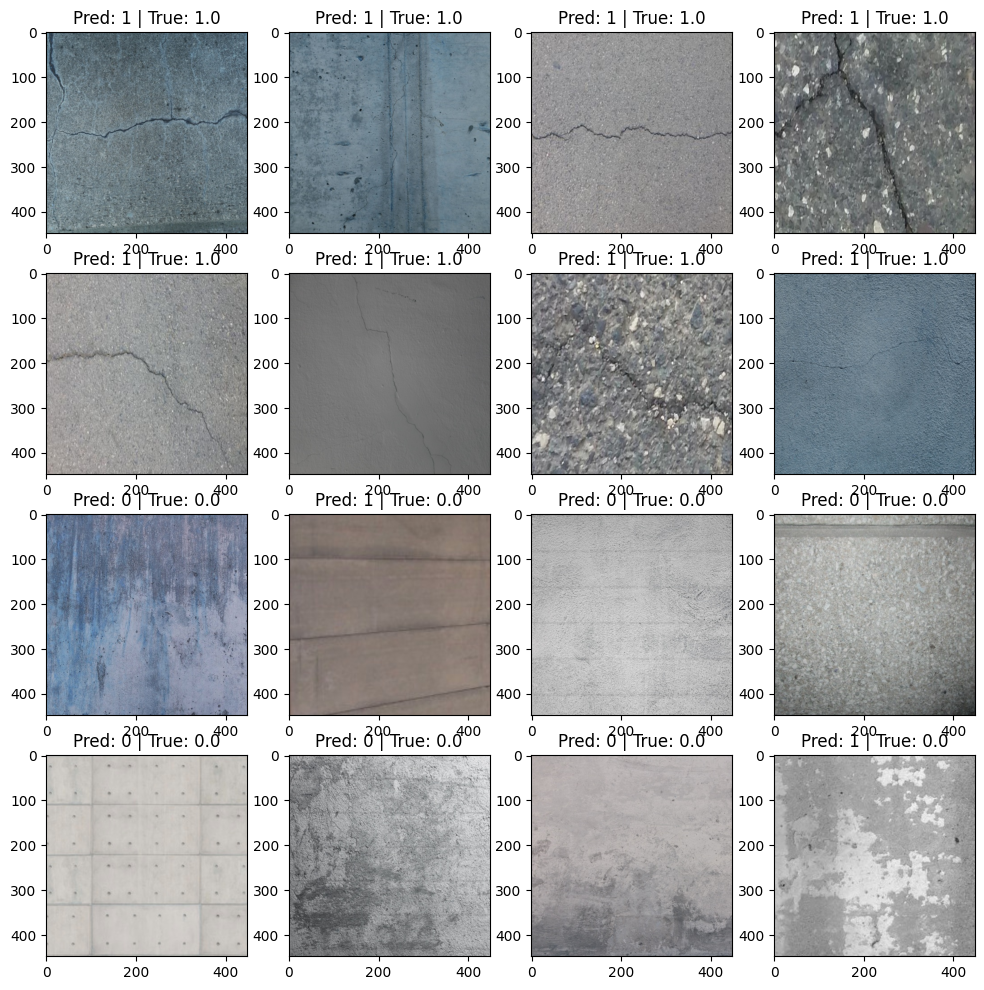

In [18]:
import matplotlib.pyplot as plt

# Show some predictions on test set (both 0 and 1)
test_dl = DataLoader(
    test_ds, batch_size=16, shuffle=True, num_workers=os.cpu_count() - 1
)

model.eval()

# collect examples
test_examples = []
n_0, n_1 = 0, 0
for batch, target in test_dl:
    for i in range(len(target)):
        if target[i].item() == 0 and n_0 < 8:
            test_examples.append((batch[i].unsqueeze(0), target[i].unsqueeze(0)))
            n_0 += 1
        elif target[i].item() == 1 and n_1 < 8:
            test_examples.append((batch[i].unsqueeze(0), target[i].unsqueeze(0)))
            n_1 += 1
    if n_0 >= 8 and n_1 >= 8:
        break

with torch.inference_mode():
    fig, ax = plt.subplots(4, 4, figsize=(12, 12))
    for i, (batch, target) in enumerate(test_examples):
        batch, target = batch.to(device), target.to(device)
        logits = model(batch)
        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).int().squeeze()

        img = batch[0].cpu().permute(1, 2, 0).numpy()
        ax[i // 4, i % 4].imshow(img)
        ax[i // 4, i % 4].set_title(f"Pred: {preds.item()} | True: {target.item()}")

In [33]:
for param in model.parameters():
    param.requires_grad = True

In [34]:
batch, target = next(iter(test_dl))

# take first image and label
image_tensor = batch[0].unsqueeze(0)  # shape: (1, C, H, W)
label = target[0].item()

print(f"Label: {label}, image shape: {image_tensor.shape}")

Label: 1.0, image shape: torch.Size([1, 3, 448, 448])


In [154]:
idx = 6
image_tensor = batch[idx].unsqueeze(0)  # shape: (1, C, H, W)
label = target[idx].item()

print(f"Label: {label}, image shape: {image_tensor.shape}")

Label: 1.0, image shape: torch.Size([1, 3, 448, 448])


In [ ]:
def tile_image(image, tile_size=112, stride=112):
    """Split an image tensor (C,H,W) into overlapping or non-overlapping tiles."""
    _, H, W = image.shape
    tiles = []
    coords = []
    for y in range(0, H - tile_size + 1, stride):
        for x in range(0, W - tile_size + 1, stride):
            tile = image[:, y:y+tile_size, x:x+tile_size]
            tiles.append(tile)
            coords.append((x, y))
    return tiles, coords

In [ ]:
tiles, coords = tile_image(image_tensor.squeeze(0), tile_size=256, stride=256)

# Predict per tile
model.eval()
tile_preds = []
for t in tiles:
    t = t.unsqueeze(0).to(device)
    pred = model(t)
    tile_preds.append(pred.detach().cpu())

In [ ]:
target_layers = [model.features[8]]
cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

for i, tile in enumerate(tiles):
    tile = tile.unsqueeze(0).to(device)
    targets = [BinaryClassifierOutputTarget(positive_class=True)]
    grayscale_cam = cam(input_tensor=tile, targets=targets)[0, :]

In [227]:
idx = 13
image_tensor = batch[idx].unsqueeze(0)  # shape: (1, C, H, W)
label = target[idx].item()

print(f"Label: {label}, image shape: {image_tensor.shape}")

Label: 1.0, image shape: torch.Size([1, 3, 448, 448])


In [228]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad

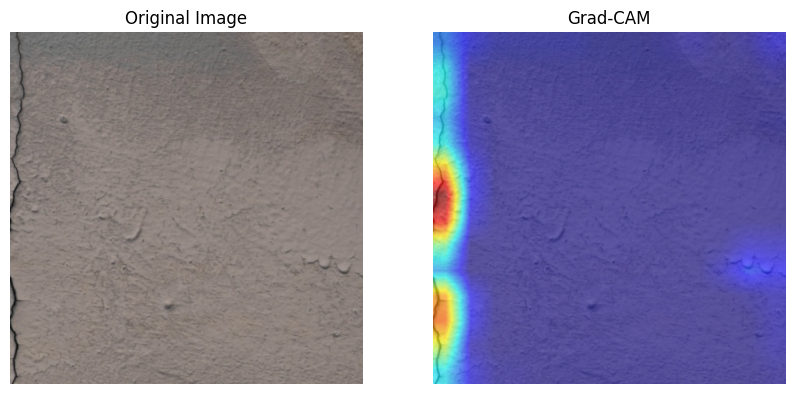

In [229]:
target_layers = [model.features[8]]
cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

targets = [BinaryClassifierOutputTarget(1)]  # True = class 1 ("crack")
grayscale_cam = cam(input_tensor=image_tensor, targets=targets)[0, :]

img = image_tensor.squeeze(0).permute(1, 2, 0).detach().numpy()
img = np.clip(img, 0, 1)  # make sure values in [0, 1]

# overlay CAM
cam_overlay = show_cam_on_image(img, grayscale_cam, use_rgb=True)

# show side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(cam_overlay)
axs[1].set_title("Grad-CAM")
axs[1].axis("off")

plt.show()

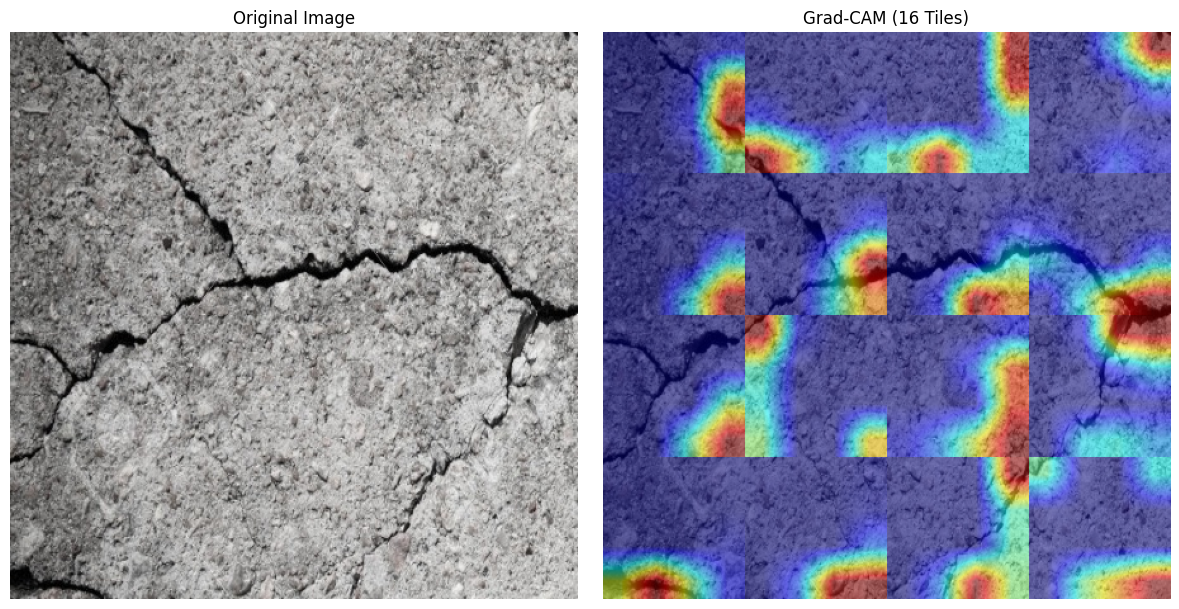

In [173]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# --- Tiling utilities ---

def tile_image(image, n_tiles=4):
    """
    Split image tensor (1, C, H, W) into n_tiles × n_tiles grid.
    Returns list of (tile_tensor, (y, x)) for later reassembly.
    """
    _, C, H, W = image.shape
    tile_h, tile_w = H // n_tiles, W // n_tiles
    tiles = []
    for i in range(n_tiles):
        for j in range(n_tiles):
            y1, y2 = i * tile_h, (i + 1) * tile_h
            x1, x2 = j * tile_w, (j + 1) * tile_w
            tile = image[:, :, y1:y2, x1:x2]
            tiles.append((tile, (y1, y2, x1, x2)))
    return tiles, (tile_h, tile_w)

def stitch_heatmaps(heatmaps, H, W, n_tiles=4):
    """
    Combine small CAMs into one large map.
    """
    tile_h, tile_w = H // n_tiles, W // n_tiles
    stitched = np.zeros((H, W))
    idx = 0
    for i in range(n_tiles):
        for j in range(n_tiles):
            y1, y2 = i * tile_h, (i + 1) * tile_h
            x1, x2 = j * tile_w, (j + 1) * tile_w
            stitched[y1:y2, x1:x2] = heatmaps[idx]
            idx += 1
    return stitched

# --- Your model and image ---

target_layers = [model.features[8]]
cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

# image_tensor: (1, C, H, W)
image_tensor = image_tensor.to(next(model.parameters()).device)
tiles, (tile_h, tile_w) = tile_image(image_tensor, n_tiles=4)

# --- Run Grad-CAM on each tile ---
heatmaps = []
for tile, _ in tiles:
    targets = [BinaryClassifierOutputTarget(1)]  # class 1 = "crack"
    grayscale_cam = cam(input_tensor=tile, targets=targets)[0, :]
    heatmaps.append(grayscale_cam)

# --- Stitch the 16 CAMs together ---
H, W = image_tensor.shape[2], image_tensor.shape[3]
stitched_cam = stitch_heatmaps(heatmaps, H, W, n_tiles=4)

# --- Prepare original image ---
img = image_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
img = np.clip(img, 0, 1)

# --- Overlay and display ---
cam_overlay = show_cam_on_image(img, stitched_cam, use_rgb=True)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(cam_overlay)
axs[1].set_title("Grad-CAM (16 Tiles)")
axs[1].axis("off")

plt.tight_layout()
plt.show()
